# Conformal prediction implementation in RIVER

Boggio Richard, Mdihi Samy, Veron Marc

In [2]:
# Install package
!pip install arff
!pip install river

You should consider upgrading via the 'c:\users\mvero\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\mvero\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


**Package loading**

In [3]:
import arff
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# River packages
from river import compose
from river import stream
from river import preprocessing
from river import metrics
from river import evaluate
import time

In River there exists several methods to forecast value in the future, tipically at t+1. If we look in detail in the time series reference:

**Time Series** : 
- **Base Forecaster**
  - it uses 2 methods *learn_one(y,X)* and *forecast(horizon, xs)*
- **HoltWinters**:
  - "This is a standard implementation of the Holt-Winters forecasting method. Certain parametrisations result in special cases, such as simple exponential smoothing. Optimal parameters and initialisation values can be determined in a batch setting. However, in an online setting, it is necessary to wait and observe enough values. The first k = max(2, seasonality) values are indeed used to initialize the components."
  - it uses the same 2 methods *learn_one(y,X)* and *forecast(horizon, xs)*
- **HorizonMetric**:
  - Used in the evaluate function : "Measures performance at each time step ahead. This allows to measure the performance of a model at each time step along the horizon. A copy of the provided regression metric is made for each time step."
- **evaluate**:
  - "Evaluates the performance of a forecaster on a time series dataset. To understand why this method is useful, it's important to understand the difference between nowcasting and forecasting. Nowcasting is about predicting a value at the next time step. This can be seen as a special case of regression, where the value to predict is the value at the next time step. In this case, the evaluate.progressive_val_score function may be used to evaluate a model via progressive validation. Forecasting models can also be evaluated via progressive validation. This is the purpose of this function. At each time step t, the forecaster is asked to predict the values at t + 1, t + 2, ..., t + horizon. The performance at each time step is measured and returned."
  
  We should probably implement a featured method like the HorizonMetric for example, which could be ConformalForecasting or something like that. 

  But we first have to understand the **aggregation of expert** of the paper. It seems they use a bagging-like technique which consists of using more than just one Forecaster but many. 

In [7]:
data = pd.read_csv("data_prices/Prices_2016_2019_extract.csv",delimiter=",")
data.shape

In [18]:
feature_names = list(data.columns)
y = np.asarray(data.Spot)[:,None]
X = np.asarray(data.iloc[:,2:])


In [17]:
print(f"Features shape {X.shape}")
print(f"Labels shape {y.shape}")

Features shape (34896, 57)
Labels shape (34896, 1)


In [52]:
# Define the streaming dataset
def get_dataset(nb_sample=None):
    assert isinstance(X, np.ndarray)
    if nb_sample is None:
        nb_sample = X.shape[0]
    # Otherwise begin from anywhere in the dataset 
    beginAt = np.random.choice(X.shape[0]-nb_sample, 1)
    index = np.asarray(list(np.arange(beginAt, beginAt+nb_sample)))
    streamed_dataset = stream.iter_array(X[index,:], y[index,:], feature_names=feature_names)
    
    return streamed_dataset, index

In [53]:
X[[1,2,3],15]

array([42.47, 42.47, 42.47])

In [54]:
nb_sample = 20000
test_dataset, _ = get_dataset(nb_sample)

TypeError: unhashable type: 'numpy.ndarray'

In [24]:
# Visualisation of the first sample contained in dataset
for x, y in test_dataset:
    print(f"Features : {x}\n")
    print(f"Label : {y}")
    break

Features : {'Date': 2.0, 'Spot': 0.0, 'hour': 0.0, 'dow_0': 0.0, 'dow_1': 0.0, 'dow_2': 1.0, 'dow_3': 0.0, 'dow_4': 0.0, 'dow_5': 30.13, 'dow_6': 25.97, 'lag_24_0': 24.93, 'lag_24_1': 24.18, 'lag_24_2': 24.58, 'lag_24_3': 24.95, 'lag_24_4': 29.84, 'lag_24_5': 37.82, 'lag_24_6': 39.96, 'lag_24_7': 38.09, 'lag_24_8': 37.66, 'lag_24_9': 36.99, 'lag_24_10': 32.64, 'lag_24_11': 32.04, 'lag_24_12': 32.75, 'lag_24_13': 31.97, 'lag_24_14': 33.01, 'lag_24_15': 33.03, 'lag_24_16': 34.71, 'lag_24_17': 35.2, 'lag_24_18': 35.28, 'lag_24_19': 33.02, 'lag_24_20': 31.39, 'lag_24_21': 29.0, 'lag_24_22': 24.91, 'lag_24_23': 22.34, 'lag_168_0': 21.03, 'lag_168_1': 19.91, 'lag_168_2': 18.27, 'lag_168_3': 20.97, 'lag_168_4': 27.25, 'lag_168_5': 33.94, 'lag_168_6': 35.95, 'lag_168_7': 33.89, 'lag_168_8': 33.29, 'lag_168_9': 33.06, 'lag_168_10': 32.0, 'lag_168_11': 31.92, 'lag_168_12': 30.65, 'lag_168_13': 28.03, 'lag_168_14': 25.46, 'lag_168_15': 27.58, 'lag_168_16': 30.01, 'lag_168_17': 32.85, 'lag_168_18'

In [ ]:
# Using the iter_progressive_val_score

# Set the max samples number to use 
max_sample = 50000
nb_to_save = 50
save_every = int(max_sample/nb_to_save)
dataset, index = get_dataset(max_sample)
start = time.time() # Begin time counter
steps = evaluate.iter_progressive_val_score(dataset, 
                                           tree.HoeffdingTreeClassifier(), 
                                           utils.Rolling(obj=metrics.Accuracy(), window_size=save_every),
                                           step=save_every)

temp_acc = []
for step in steps:
    temp_acc.append(step['Rolling'].get())
end = time.time() # End time counter
print(f"Run in {end-start:.2f} seconds")

Run in 113.84 seconds


Using custom loop

It allows to get both the accuracy smoothed over the dataset, and the rolling one. Also, we can use the Cache module of River which speed up the process if we go over a dataset several times. In our case, as we want to do some tuning of hyperparameter, and pass on the dataset for each one, it can be very useful.

**!!! ATTENTION !!!** after many attempt, it seems the method is not as much as stable. We tried several combinaison, and some seem to not work well while other do. For example, if we streamed on Numpy array, without Verbose, the loop on best KNN kill the RAM of Colab... Same thing for the other model (we stopped the run after 45min). Then we tried streaming from pandas, not much changes. And finally we set the verbose at True. This change make the custom function really fast, maybe as it interact with the user interface. It has to be investigated to be corrected properly. But for now we are ok using it like that.

Anyway, the 2 methods returns the same rolling accuracy so we can use it anyway, in our case for parameters tuning.

In [82]:
class custom_progressive_val_score:
    def __init__(self, dataset, key):
        self.dataset = dataset
        self.cache = stream.Cache()
        self.key = key # need to set it otherwise it can increment an existing
        # cache
        self.model = None

    def run (self, model, step=1, verbose=True):
        '''
        For each individual sample in the dataset : 
        1. predict the class
        2. update the metric score 
        3. update the model weights
        Return : the list of metric scores
        '''
        self.model = model
        start = time.time()

        acc = metrics.Accuracy()
        roll_acc = utils.Rolling(obj=metrics.Accuracy(), window_size=1000)

        list_acc = []
        list_roll_acc = []
        i = 0
        for x, y in self.cache(self.dataset, key=self.key):
            # Predict the class of the sample
            try:
                y_hat = self.model.predict_proba_one(x)
                # Compute the metric
                if len(y_hat)!=0:
                    y_hat = max(y_hat, key=y_hat.get)
                    acc.update(y, y_hat)
                    roll_acc.update(y, y_hat)

            except NotImplementedError: # for the onetoone classifier
                y_hat = self.model.predict_one(x)
                if not y_hat is None:
                    acc.update(y, y_hat)
                    roll_acc.update(y, y_hat)

            # Incremente the state of the model
            self.model.learn_one(x, y)

            # Incremente the list of metric values
            if (i+1)%step==0:
                list_acc.append(acc.get())
                list_roll_acc.append(roll_acc.get())
                if verbose:
                    print(f"{i+1} samples : full = {list_acc[-1]*100:0.2f}% | roll = {list_roll_acc[-1]*100:0.2f}%")
            
            i+=1

        end = time.time()
        print(f"\nStream passed in {end-start:.2f} seconds")
        return list_acc, list_roll_acc

In [ ]:
# Reinitiliaze the model, otherwise we keep the states
# and also the dataset but with the same index as before
dataset, index = get_dataset(50000)

testing_mode = custom_progressive_val_score(dataset,'firsttry')
# Launch the learning with the custom function
tempcustom_acc, tempcustom_acc_roll = testing_mode.run(model=tree.HoeffdingTreeClassifier(), 
                                                        step=save_every)

1000 samples : full = 60.36% | roll = 60.36%
2000 samples : full = 56.03% | roll = 51.70%
3000 samples : full = 49.35% | roll = 36.00%
4000 samples : full = 46.31% | roll = 37.20%
5000 samples : full = 44.49% | roll = 37.20%
6000 samples : full = 43.72% | roll = 39.90%
7000 samples : full = 44.02% | roll = 45.80%
8000 samples : full = 45.79% | roll = 58.20%
9000 samples : full = 47.35% | roll = 59.80%
10000 samples : full = 49.79% | roll = 71.80%
11000 samples : full = 50.93% | roll = 62.30%
12000 samples : full = 50.98% | roll = 51.50%
13000 samples : full = 51.69% | roll = 60.20%
14000 samples : full = 51.43% | roll = 48.00%
15000 samples : full = 52.22% | roll = 63.40%
16000 samples : full = 53.87% | roll = 78.50%
17000 samples : full = 55.04% | roll = 73.90%
18000 samples : full = 56.40% | roll = 79.40%
19000 samples : full = 57.46% | roll = 76.60%
20000 samples : full = 58.59% | roll = 80.10%
21000 samples : full = 59.65% | roll = 80.80%
22000 samples : full = 60.86% | roll = 86.3

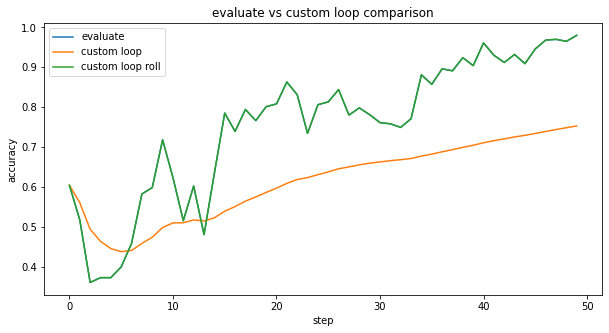

In [ ]:
# Plot the accuracy of the 2 methods to see if it matches
metrics_arr = np.column_stack([temp_acc, tempcustom_acc, tempcustom_acc_roll])
plt.figure(figsize=(10,5))
plt.plot(metrics_arr)
plt.xlabel("step")
plt.ylabel("accuracy")
plt.legend(["evaluate","custom loop","custom loop roll"])
plt.title("evaluate vs custom loop comparison")
plt.show()

We see that the results on 2 methods are the same. As we will tune some hyperparameter, the use of the cache of the dataset will speed up the process, so we will use the custom function. It allows also to obtain the smoothed accuracy. 

Let's tune the tree by making the parameters varying
We will use a dataset on 10k samples and check on a bigger one after

In [ ]:
runAgain = False
if runAgain:
    # We set the lists for the different parameters
    # on which we will loop
    list_split_criterion = ['gini', 'info_gain', 'hellinger']
    list_leaf_pred_mechanism = ['mc', 'nb', 'nba']
    list_grace_period = [100, 200, 500]
    list_max_depth = [1,4,8]

    max_sample = 20000
    save_every = int(max_sample/nb_to_save)

    dataset,_ = get_dataset(max_sample)
    
    test_model = custom_progressive_val_score(dataset,'tune_tree')
    best_model_accuracy = 0
    # Let's tune the grace period and depth with the default leaf pred mechanism and split criterion
    for split in list_split_criterion:
        for leaf_pred in list_leaf_pred_mechanism:
            for grace in list_grace_period:
                for depth in list_max_depth:
                    
                    # Launch
                    temp_acc, temp_acc_roll = test_model.run(
                                tree.HoeffdingTreeClassifier(grace_period=grace,
                                                            max_depth=depth,
                                                            split_criterion=split,
                                                            leaf_prediction=leaf_pred), 
                                step=save_every,
                                verbose = False)
                    
                    # Information
                    print(f"Split_criterion: {split} | Leaf_pred: {leaf_pred} "
                          f" | Grace_period: {grace} | Max_depth: {depth} "
                          f"===> Accuracy = {temp_acc[-1]*100:.2f}%")
                    
                    if step['Rolling'].get() > best_model_accuracy:
                        best_model_accuracy = step['Rolling'].get()
                        list_best_onerest = temp_acc



Stream passed in 21.67 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 100 | Max_depth: 1 ===> Accuracy = 34.63%

Stream passed in 9.44 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 100 | Max_depth: 4 ===> Accuracy = 49.13%

Stream passed in 11.13 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 100 | Max_depth: 8 ===> Accuracy = 49.13%

Stream passed in 5.96 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 200 | Max_depth: 1 ===> Accuracy = 34.55%

Stream passed in 9.12 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 200 | Max_depth: 4 ===> Accuracy = 47.20%

Stream passed in 11.87 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 200 | Max_depth: 8 ===> Accuracy = 47.89%

Stream passed in 5.87 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 500 | Max_depth: 1 ===> Accuracy = 34.30%

Stream passed in 9.36 seconds
Split_criterion: gini | Leaf_pred: mc  | Grace_period: 500 | Max_depth

First notable thing is that the gini criterion is much faster. Maybe it's due to the algorithm structure, but also maybe because of the cache management. That would need to be investigated further.

Anyway, we see that the performance with the naive bayes classifier is better overrall, with a smaller grace_period. It seems to be a bit faster than nba (Naive Bayes Adaptive).


So we will use one of the best in the list above : Split_criterion: gini | Leaf_pred: nba  | Grace_period: 100 | Max_depth: 4


We now will look at the impact of the *nb_threshold* parameter (Number of instances a leaf should observe before allowing Naive Bayes). 

In [ ]:
runAgain = False
if runAgain:

    list_nb_threshold = [1,5,10]

    max_sample = 20000
    save_every = int(max_sample/nb_to_save)
    dataset,_ = get_dataset(max_sample)

    test_model = custom_progressive_val_score(dataset,'tune_tree_threshold')

    for nb_threshold in list_nb_threshold:
        model_to_score = tree.HoeffdingTreeClassifier(grace_period=100,
                                                      max_depth=4,
                                                      split_criterion='gini',
                                                      leaf_prediction='nb',
                                                      nb_threshold=nb_threshold)
        # Launch
        temp_acc, temp_acc_roll = test_model.run(
                    model_to_score, 
                    step=save_every,
                    verbose = False)
        
          # Tuning information
        print(f"nb_threshold: {nb_threshold} ===> {temp_acc[-1]*100:.2f}%")


Stream passed in 42.35 seconds
nb_threshold: 1 ===> 60.92%

Stream passed in 16.35 seconds
nb_threshold: 5 ===> 60.91%

Stream passed in 19.08 seconds
nb_threshold: 10 ===> 60.90%


We see no real changes with nb_threshold.
But here we see the performance of the cache management : first stream in 42 second vs only 16 the one after.


Also, we notice a little improvement when we don't use shuffle for the dataset, meaning the model is more precise when the data is in the same order as in the file. But the data are not described to be time-ordered, so we shouldn't care about the concept drift. 

Sample size=100000
2000 samples : full = 56.13% | roll = 51.70%
4000 samples : full = 50.94% | roll = 55.50%
6000 samples : full = 56.03% | roll = 63.80%
8000 samples : full = 53.57% | roll = 33.50%
10000 samples : full = 53.71% | roll = 64.40%
12000 samples : full = 55.12% | roll = 62.10%
14000 samples : full = 54.60% | roll = 47.80%
16000 samples : full = 56.08% | roll = 78.60%
18000 samples : full = 58.49% | roll = 80.30%
20000 samples : full = 60.92% | roll = 80.30%
22000 samples : full = 62.69% | roll = 82.20%
24000 samples : full = 64.25% | roll = 80.60%
26000 samples : full = 65.62% | roll = 80.50%
28000 samples : full = 66.57% | roll = 75.60%
30000 samples : full = 67.74% | roll = 85.70%
32000 samples : full = 68.69% | roll = 82.80%
34000 samples : full = 69.38% | roll = 81.80%
36000 samples : full = 69.94% | roll = 75.50%
38000 samples : full = 70.43% | roll = 78.00%
40000 samples : full = 70.95% | roll = 85.90%
42000 samples : full = 71.58% | roll = 86.00%
44000 samples : ful

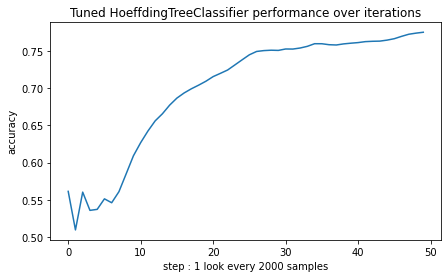

In [ ]:
# Get the best tree with 100k data line
runAgain = True
if runAgain:
    max_sample = 100000
    save_every = int(max_sample/nb_to_save)

    ########### DATASTREAM CONFIG ###########
    dataset, index = get_dataset(max_sample)
    test_model = custom_progressive_val_score(dataset,'best_tree')
    # Define the model we want to test
    model_to_score = tree.HoeffdingTreeClassifier(grace_period=100,
                                                  max_depth=4,
                                                  split_criterion='gini',
                                                  leaf_prediction='nb')
    
    # Launch it
    best_tree, best_tree_roll = test_model.run(
                model_to_score, 
                step=save_every,
                verbose = True)
    
    plt.figure(figsize=(7,4))
    plt.plot(best_tree)
    plt.xlabel(f"step : 1 look every {save_every} samples")
    plt.ylabel("accuracy")
    plt.title("Tuned HoeffdingTreeClassifier performance over iterations")
    plt.show()

In [ ]:
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_tree.npy", np.asarray(best_tree))
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_tree_roll.npy", np.asarray(best_tree_roll))

### Adaptative Random Forest

We keep the same configuration of a single tree as above

In [ ]:
from river import ensemble

In [ ]:
runAgain = False
if runAgain:
    max_sample = 20000
    save_every = int(max_sample/nb_to_save)
    
    # Set the lists of hyperparameters to test
    list_nb_trees = [5,7,10,12]

    dataset, _ = get_dataset(max_sample)
    test_model = custom_progressive_val_score(dataset,'test_forest')
    for nb_trees in list_nb_trees:
        # Redifine the metric and the model                    
        model_to_score = ensemble.AdaptiveRandomForestClassifier(n_models=nb_trees,
                                                        seed=42,
                                                        grace_period=100,
                                                        max_depth=4,
                                                        split_criterion='gini',
                                                        leaf_prediction='nb')
        # Launch
        temp_acc, temp_acc_roll = test_model.run(
                    model_to_score, 
                    step=save_every,
                    verbose = False)
        
        # Tuning information
        print(f"nb_trees: {nb_trees} ===> {temp_acc[-1]*100:.2f}%")


Stream passed in 56.41 seconds
nb_trees: 5 ===> 71.75%

Stream passed in 44.12 seconds
nb_trees: 7 ===> 71.30%

Stream passed in 65.97 seconds
nb_trees: 10 ===> 72.09%

Stream passed in 80.26 seconds
nb_trees: 12 ===> 72.89%


We improved by about 8 points the results obtained on a single tree, if we set the number of trees at 5 in the random forest. The more the number of trees doesn't lead to more accuracy. we see that 5 trees gives good results, and seems to be sufficient for a forest.

Sample size=100000
2000 samples : full = 67.58% | roll = 67.70%
4000 samples : full = 69.12% | roll = 73.20%
6000 samples : full = 69.26% | roll = 65.60%
8000 samples : full = 68.35% | roll = 65.80%
10000 samples : full = 67.57% | roll = 72.10%
12000 samples : full = 67.06% | roll = 63.20%
14000 samples : full = 66.08% | roll = 56.80%
16000 samples : full = 66.60% | roll = 84.10%
18000 samples : full = 68.53% | roll = 88.60%
20000 samples : full = 70.86% | roll = 89.00%
22000 samples : full = 72.72% | roll = 93.80%
24000 samples : full = 74.01% | roll = 82.70%
26000 samples : full = 75.16% | roll = 88.50%
28000 samples : full = 75.89% | roll = 80.60%
30000 samples : full = 76.42% | roll = 82.90%
32000 samples : full = 76.96% | roll = 86.40%
34000 samples : full = 77.39% | roll = 84.40%
36000 samples : full = 77.95% | roll = 88.10%
38000 samples : full = 78.72% | roll = 93.80%
40000 samples : full = 79.49% | roll = 97.60%
42000 samples : full = 80.20% | roll = 94.20%
44000 samples : ful

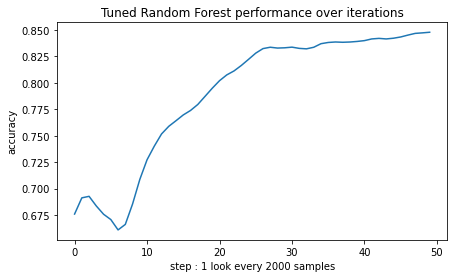

In [ ]:
# Run the best forest on 100k line
runAgain = True
if runAgain:
    max_sample = 100000
    save_every = int(max_sample/nb_to_save)
    dataset, _ = get_dataset(max_sample)

    test_model = custom_progressive_val_score(dataset,'best_forest')

    # Define the model we want to test
    model_to_score = ensemble.AdaptiveRandomForestClassifier(n_models=5,
                                                    seed=42,
                                                    grace_period=100,
                                                    max_depth=4,
                                                    split_criterion='info_gain',
                                                    leaf_prediction='nb')
    # Launch
    best_forest, best_forest_roll = test_model.run(
                model_to_score, 
                step=save_every,
                verbose = True)
    
    plt.figure(figsize=(7,4))
    plt.plot(best_forest)
    plt.xlabel(f"step : 1 look every {save_every} samples")
    plt.ylabel("accuracy")
    plt.title("Tuned Random Forest performance over iterations")
    plt.show()

We see also that the accuracy increases as we feed the model with more and more observations, meaning the potential performance in real condition, on longer stream, could be better.

In [ ]:
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_forest.npy", np.asarray(best_forest))
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_forest_roll.npy", np.asarray(best_forest_roll))

### KNN Classifier

In [ ]:
from river import neighbors

In [ ]:
runAgain = False
if runAgain:
    max_sample = 5000
    save_every = int(max_sample/nb_to_save)
    dataset, _ = get_dataset(max_sample)
    test_model = custom_progressive_val_score(dataset,'test_knn')

    # Set the parameters we want to test
    list_NN = [3,5,7]
    list_window_size = [100,500,1000] 
    # We keep default min_distance_keep at 0 because 
    # if > 0 (0.01, 0.05...) accuracy ~35% and not increasing
    
    best_model_accuracy = 0.0
    list_best_KNN = []
    for NN in list_NN:
        for window_size in list_window_size:
            # Redifine the metric and the model
            model_to_sore = neighbors.KNNClassifier(n_neighbors=NN,
                                                    window_size=window_size)
            # Launch
            temp_acc, temp_acc_roll = test_model.run(
                        model_to_score, 
                        step=save_every,
                        verbose = False)
            
              # Tuning information
            print(f"NN: {NN} | window_size: {window_size} ===> {temp_acc[-1]*100:.2f}%")


Stream passed in 23.89 seconds
NN: 3 | window_size: 100 ===> 71.26%

Stream passed in 18.00 seconds
NN: 3 | window_size: 500 ===> 71.20%

Stream passed in 16.57 seconds
NN: 3 | window_size: 1000 ===> 71.56%

Stream passed in 16.86 seconds
NN: 5 | window_size: 100 ===> 70.92%

Stream passed in 19.98 seconds
NN: 5 | window_size: 500 ===> 70.40%

Stream passed in 15.83 seconds
NN: 5 | window_size: 1000 ===> 72.38%

Stream passed in 17.33 seconds
NN: 7 | window_size: 100 ===> 72.36%

Stream passed in 19.28 seconds
NN: 7 | window_size: 500 ===> 69.78%

Stream passed in 16.93 seconds
NN: 7 | window_size: 1000 ===> 71.44%


We see that the parameter that most influences the performance of the model is the window_size. That's obvious since we increase the observation window, so more data are available to estimate the classification. But in a stream setting we can't afford so much storage as the algorithm runs slower and slower as we increase the window. 
Here we will set the window at 500, and we will use 5 neighboors

2000 samples : full = 76.34% | roll = 76.90%
4000 samples : full = 79.69% | roll = 85.90%
6000 samples : full = 80.78% | roll = 81.00%
8000 samples : full = 80.16% | roll = 80.90%
10000 samples : full = 80.22% | roll = 84.00%
12000 samples : full = 79.86% | roll = 76.30%
14000 samples : full = 79.01% | roll = 70.70%
16000 samples : full = 79.32% | roll = 90.00%
18000 samples : full = 80.59% | roll = 92.10%
20000 samples : full = 82.15% | roll = 95.90%
22000 samples : full = 83.49% | roll = 98.30%
24000 samples : full = 84.64% | roll = 97.10%
26000 samples : full = 85.59% | roll = 96.70%
28000 samples : full = 86.26% | roll = 93.40%
30000 samples : full = 86.85% | roll = 94.90%
32000 samples : full = 87.37% | roll = 95.40%
34000 samples : full = 87.78% | roll = 94.00%
36000 samples : full = 88.19% | roll = 95.60%
38000 samples : full = 88.66% | roll = 97.80%
40000 samples : full = 89.17% | roll = 99.30%
42000 samples : full = 89.61% | roll = 97.70%
44000 samples : full = 89.99% | roll =

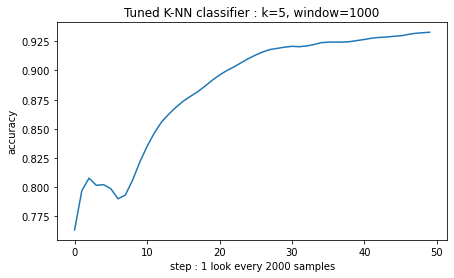

In [ ]:
# Put the best KNN over 100k data line
runAgain = False
if runAgain:
    max_sample = 100000
    save_every = int(max_sample/nb_to_save)
    dataset, _ = get_dataset(max_sample)

    test_model = custom_progressive_val_score(dataset,'best_knn')

    # Redifine the metric and the model
    model_to_score = neighbors.KNNClassifier(n_neighbors=5,
                                    window_size=500)
    
    # Redifine the metric and the model
    model_to_score = neighbors.KNNClassifier(n_neighbors=5,
                                    window_size=1000)

    # Launch
    best_KNN, best_KNN_roll = test_model.run(
                model_to_score, 
                step=save_every,
                verbose = True)
    plt.figure(figsize=(7,4))
    plt.plot(best_KNN)
    plt.xlabel(f"step : 1 look every {save_every} samples")
    plt.ylabel("accuracy")
    plt.title("Tuned K-NN classifier : k=5, window=1000")
    plt.show()

We are doing better than with the random forest but it still takes a lot of time to run, and it is worst when we use the iter_progressive_val_score. We had to use a simple loop, and it took more than 40 minutes to run on Colab.

In [ ]:
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_KNN.npy", np.asarray(best_KNN))
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_KNN_roll.npy", np.asarray(best_KNN_roll))

### OnevsOne Classifier

In [68]:
from river import multiclass as mc
from river import linear_model as lm
from river import naive_bayes  as nb

In [86]:
runAgain = True
if runAgain:
    max_sample = 20000
    save_every = int(max_sample/nb_to_save)
    dataset, index = get_dataset(max_sample)
    test_model = custom_progressive_val_score(dataset,'test_onevsone')

    # Set the lists of hyperparameters to test
    models = [lm.LogisticRegression(),lm.PAClassifier(), lm.ALMAClassifier()]
    
    for model in models:
        # Redifine the metric and the model
        model_to_score = mc.OneVsOneClassifier(model)

        # Launch
        temp_acc, temp_acc_roll = test_model.run(
                    model_to_score, 
                    step=save_every,
                    verbose = True)
        
        # Tuning information
        print(f"Classifier : {model} ===> {temp_acc[-1]*100:.2f}%")

Sample size=20000
400 samples : full = 59.95% | roll = 59.95%
800 samples : full = 62.36% | roll = 62.36%
1200 samples : full = 57.31% | roll = 56.80%
1600 samples : full = 57.67% | roll = 54.50%
2000 samples : full = 56.58% | roll = 53.40%
2400 samples : full = 56.65% | roll = 56.80%
2800 samples : full = 55.70% | roll = 52.80%
3200 samples : full = 55.33% | roll = 51.70%
3600 samples : full = 57.52% | roll = 59.50%
4000 samples : full = 58.84% | roll = 69.50%
4400 samples : full = 59.68% | roll = 70.50%
4800 samples : full = 60.50% | roll = 69.80%
5200 samples : full = 60.21% | roll = 63.30%
5600 samples : full = 59.96% | roll = 58.60%
6000 samples : full = 59.56% | roll = 56.30%
6400 samples : full = 59.50% | roll = 56.60%
6800 samples : full = 58.75% | roll = 53.40%
7200 samples : full = 57.79% | roll = 46.80%
7600 samples : full = 57.54% | roll = 46.90%
8000 samples : full = 57.66% | roll = 54.10%
8400 samples : full = 56.98% | roll = 53.60%
8800 samples : full = 56.88% | roll = 4

Faster than the other methods, especially for logistic regression, but an average score a bit lower. 

Sample size=100000
2000 samples : full = 67.10% | roll = 70.20%
4000 samples : full = 71.98% | roll = 84.00%
6000 samples : full = 73.22% | roll = 72.90%
8000 samples : full = 72.24% | roll = 67.90%
10000 samples : full = 72.66% | roll = 81.00%
12000 samples : full = 72.77% | roll = 73.00%
14000 samples : full = 72.09% | roll = 65.80%
16000 samples : full = 73.29% | roll = 93.00%
18000 samples : full = 75.67% | roll = 95.50%
20000 samples : full = 77.73% | roll = 96.20%
22000 samples : full = 79.45% | roll = 97.80%
24000 samples : full = 80.87% | roll = 95.70%
26000 samples : full = 82.10% | roll = 97.20%
28000 samples : full = 83.13% | roll = 95.70%
30000 samples : full = 84.03% | roll = 96.50%
32000 samples : full = 84.73% | roll = 95.70%
34000 samples : full = 85.38% | roll = 95.70%
36000 samples : full = 85.94% | roll = 95.40%
38000 samples : full = 86.55% | roll = 97.80%
40000 samples : full = 87.18% | roll = 99.60%
42000 samples : full = 87.74% | roll = 98.60%
44000 samples : ful

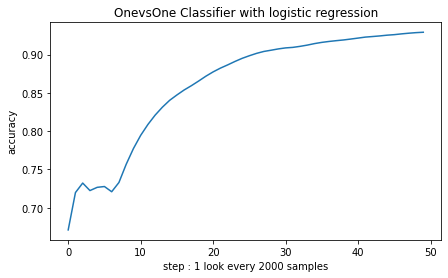

In [87]:
# Pass the best onevsone over 100k data line

max_sample = 100000
save_every = int(max_sample/nb_to_save)
dataset, _ = get_dataset(max_sample)
test_model = custom_progressive_val_score(dataset,'best_onevsone')
model_to_score = mc.OneVsOneClassifier(lm.PAClassifier())

# Launch
best_oneone, best_oneone_roll = test_model.run(
            model_to_score, 
            step=save_every,
            verbose = True)

plt.figure(figsize=(7,4))
plt.plot(best_oneone)
plt.xlabel(f"step : 1 look every {save_every} samples")
plt.ylabel("accuracy")
plt.title("OnevsOne Classifier with logistic regression")
plt.show()

In [88]:
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_oneone.npy", np.asarray(best_oneone))
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_oneone_roll.npy", np.asarray(best_oneone_roll))

### OnevsRest Classifier

In [77]:
runAgain = True
if runAgain:
    max_sample = 20000
    save_every = int(max_sample/nb_to_save)
    dataset, index = get_dataset(max_sample)
    test_model = custom_progressive_val_score(dataset,'test_onevsrest')

    # Set the lists of hyperparameters to test
    models = [lm.LogisticRegression(), lm.PAClassifier(), lm.ALMAClassifier()]
  
    for model in models:
        # Redifine the model
        model_to_score = mc.OneVsRestClassifier(model)

        # Launch
        temp_acc, temp_acc_roll = test_model.run(
                    model_to_score, 
                    step=save_every,
                    verbose = False)
        
        # Tuning information
        print(f"Classifier : {model} ===> {temp_acc[-1]*100:.2f}%")

Sample size=20000

Stream passed in 23.45 seconds
Classifier : LogisticRegression ===> 64.83%

Stream passed in 15.30 seconds
Classifier : PAClassifier ===> 77.31%

Stream passed in 7.05 seconds
Classifier : ALMAClassifier ===> 77.38%


We see better performance with the ALMAClassifier. About 13 points above the logistic regression.  

**bug?** it appears that we are unable to pass aother loss function to the LogisticRegression. The gradient method doesn't work. 

Sample size=100000
2000 samples : full = 68.08% | roll = 70.80%
4000 samples : full = 72.44% | roll = 83.80%
6000 samples : full = 72.61% | roll = 69.30%
8000 samples : full = 72.07% | roll = 68.90%
10000 samples : full = 72.19% | roll = 78.80%
12000 samples : full = 72.30% | roll = 72.70%
14000 samples : full = 71.61% | roll = 64.20%
16000 samples : full = 72.82% | roll = 92.20%
18000 samples : full = 75.25% | roll = 96.10%
20000 samples : full = 77.38% | roll = 96.50%
22000 samples : full = 79.11% | roll = 97.40%
24000 samples : full = 80.49% | roll = 95.10%
26000 samples : full = 81.70% | roll = 96.30%
28000 samples : full = 82.68% | roll = 94.70%
30000 samples : full = 83.55% | roll = 95.90%
32000 samples : full = 84.26% | roll = 95.40%
34000 samples : full = 84.88% | roll = 94.50%
36000 samples : full = 85.45% | roll = 94.60%
38000 samples : full = 86.04% | roll = 97.00%
40000 samples : full = 86.68% | roll = 99.10%
42000 samples : full = 87.25% | roll = 98.20%
44000 samples : ful

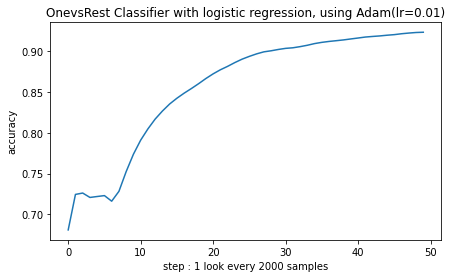

In [78]:
# Pass the best onevsrest over 100k data line

max_sample = 100000
save_every = int(max_sample/nb_to_save)
dataset, _ = get_dataset(max_sample)
test_model = custom_progressive_val_score(dataset,'best_onevsrest')

# Redifine and the model
model_to_score = mc.OneVsRestClassifier(lm.ALMAClassifier())

# Launch
best_onerest, best_onerest_roll = test_model.run(
            model_to_score, 
            step=save_every,
            verbose = True)

plt.figure(figsize=(7,4))
plt.plot(best_onerest)
plt.xlabel(f"step : 1 look every {save_every} samples")
plt.ylabel("accuracy")
plt.title("OnevsRest Classifier with logistic regression, using Adam(lr=0.01)")
plt.show()

In [80]:
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_onerest.npy", np.asarray(best_onerest))
np.save("/content/gdrive/MyDrive/X/M2DS-DataStream/best_onerest_roll.npy", np.asarray(best_onerest_roll))

# Comparison

In [90]:
print(f"best_tree = {best_tree[-1]*100:.2f}%\n"
      f"best_forest = {best_forest[-1]*100:.2f}%\n"
      f"best_KNN = {best_KNN[-1]*100:.2f}%\n"
      f"best_oneone = {best_oneone[-1]*100:.2f}%\n"
      f"best_onerest = {best_onerest[-1]*100:.2f}%\n")

best_tree = 77.55%
best_forest = 84.79%
best_KNN = 93.28%
best_oneone = 92.92%
best_onerest = 92.36%



In [91]:
print(f"best_tree_roll = {best_tree_roll[-1]*100:.2f}%\n"
      f"best_forest_roll = {best_forest_roll[-1]*100:.2f}%\n"
      f"best_KNN_roll = {best_KNN_roll[-1]*100:.2f}%\n"
      f"best_oneone_roll = {best_oneone_roll[-1]*100:.2f}%\n"
      f"best_onerest_roll = {best_onerest_roll[-1]*100:.2f}%\n")

best_tree_roll = 83.40%
best_forest_roll = 88.60%
best_KNN_roll = 94.80%
best_oneone_roll = 94.90%
best_onerest_roll = 93.40%



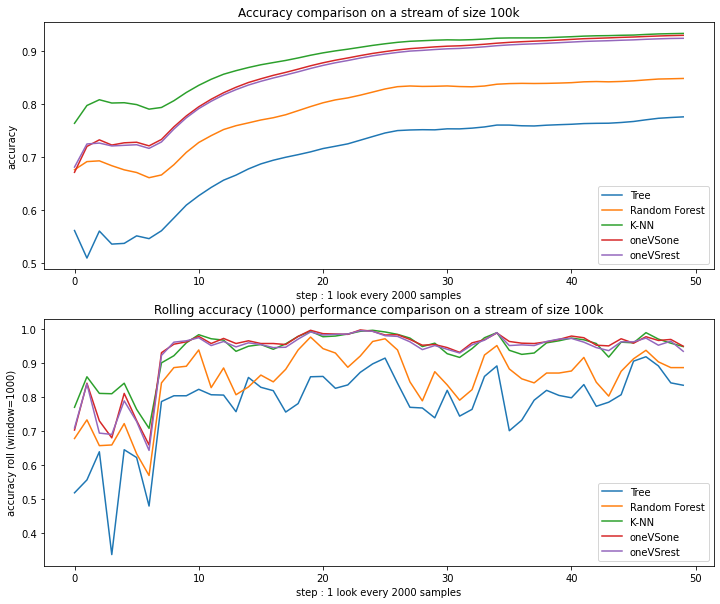

In [95]:
# Plot all the series done on 100k observations
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
metrics_arr = np.column_stack([best_tree, best_forest, best_KNN, best_oneone, best_onerest])
plt.plot(metrics_arr)
plt.xlabel(f"step : 1 look every {save_every} samples")
plt.ylabel("accuracy")
plt.legend(["Tree","Random Forest","K-NN","oneVSone","oneVSrest"])
plt.title("Accuracy comparison on a stream of size 100k")

plt.subplot(2,1,2)
metrics_arr = np.column_stack([best_tree_roll, best_forest_roll, best_KNN_roll, best_oneone_roll, best_onerest_roll])
plt.plot(metrics_arr)
plt.xlabel(f"step : 1 look every {save_every} samples")
plt.ylabel("accuracy roll (window=1000)")
plt.legend(["Tree","Random Forest","K-NN","oneVSone","oneVSrest"])
plt.title("Rolling accuracy (1000) performance comparison on a stream of size 100k")

plt.show()